In [6]:
# Kaggle notebook link: https://www.kaggle.com/code/quangtranvo/lab-8-medical-image-segmentation#Plot-Model-Accuracy
# Paper Reference: https://arxiv.org/pdf/1505.04597
import os

chaseDB1_dataset_root = os.path.join('..', 'data', 'CHASEDB1')

if os.path.exists(chaseDB1_dataset_root):
    print(f"Dataset path set to: {chaseDB1_dataset_root}")
else:
    print(f"Error: Dataset path not found at {chaseDB1_dataset_root}")


Dataset path set to: ..\data\CHASEDB1


In [7]:
from IPython.display import clear_output

%pip install -q tensorflow==2.4.1

clear_output()

In [8]:
%pip install segmentation-models

Note: you may need to restart the kernel to use updated packages.


c:\Python312\python.exe: No module named pip.__main__; 'pip' is a package and cannot be directly executed


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Reference:
Paper: https://arxiv.org/pdf/1505.04597.pdf

# To do
1. Preprocess image and data (done)
https://stackoverflow.com/questions/58050113/imagedatagenerator-for-semantic-segmentation

2. Self-implement U-net (done)
3. Train U-Net
4. Metrics for segmentation problems (https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)
5. Use other models as encoder for U-Net
https://github.com/qubvel/segmentation_models
    

Paper: https://arxiv.org/pdf/1505.04597.pdf

# Inspect data

In [6]:
import os

print("Contents of DRIVE dataset:")
for root, dirs, files in os.walk(drive_dataset_root):
    print(root)
    print("  Dirs:", dirs)
    print("  Files:", files)

Contents of DRIVE dataset:
/content/drive/MyDrive/Retinal_Vessel_Segmentation_Datasets/CHASEDB1
  Dirs: ['test', 'training']
  Files: []
/content/drive/MyDrive/Retinal_Vessel_Segmentation_Datasets/CHASEDB1/test
  Dirs: ['1st_manual', '2nd_manual', 'images']
  Files: []
/content/drive/MyDrive/Retinal_Vessel_Segmentation_Datasets/CHASEDB1/test/1st_manual
  Dirs: []
  Files: ['Image_11L_1stHO.png', 'Image_10R_1stHO.png', 'Image_11R_1stHO.png', 'Image_09L_1stHO.png', 'Image_09R_1stHO.png', 'Image_08R_1stHO.png', 'Image_08L_1stHO.png', 'Image_10L_1stHO.png', 'Image_14L_1stHO.png', 'Image_13R_1stHO.png', 'Image_13L_1stHO.png', 'Image_12L_1stHO.png', 'Image_14R_1stHO.png', 'Image_12R_1stHO.png']
/content/drive/MyDrive/Retinal_Vessel_Segmentation_Datasets/CHASEDB1/test/2nd_manual
  Dirs: []
  Files: ['Image_14L_2ndHO.png', 'Image_14R_2ndHO.png', 'Image_12R_2ndHO.png', 'Image_13R_2ndHO.png', 'Image_10L_2ndHO.png', 'Image_11R_2ndHO.png', 'Image_11L_2ndHO.png', 'Image_10R_2ndHO.png', 'Image_13L_2

In [7]:
import os

# TRAIN SET
TRAIN_DATA_DIR = os.path.join(drive_dataset_root, "training", "images")
TRAIN_SEGMENT_DIR = os.path.join(drive_dataset_root, "training", "1st_manual")
#TRAIN_VESSEL_MASK_DIR = os.path.join(drive_root, "training", "mask")  # contains vessel masks for training for DRIVE

# TEST SET
TEST_DATA_DIR = os.path.join(drive_dataset_root, "test", "images")
TEST_SEGMENT_DIR = os.path.join(drive_dataset_root, "test", "1st_manual")

In [8]:
print("Sample train images:", sorted(os.listdir(TRAIN_DATA_DIR))[:5])
print("Sample train manual segmentation:", sorted(os.listdir(TRAIN_SEGMENT_DIR))[:5])
print("Sample test images:", sorted(os.listdir(TEST_DATA_DIR))[:5])
print("Sample test manual segmentation:", sorted(os.listdir(TEST_SEGMENT_DIR))[:5])
#print("Sample test masks:", sorted(os.listdir(TEST_MASK_DIR))[:5])

print("Train image count:", len(os.listdir(TRAIN_DATA_DIR)))
print("Train manual segmentation count:", len(os.listdir(TRAIN_SEGMENT_DIR)))
print("Test image count:", len(os.listdir(TEST_DATA_DIR)))
print("Test manual segmentation count:", len(os.listdir(TEST_SEGMENT_DIR)))
#print("Test mask count:", len(os.listdir(TEST_MASK_DIR)))

Sample train images: ['Image_01L.jpg', 'Image_01R.jpg', 'Image_02L.jpg', 'Image_02R.jpg', 'Image_03L.jpg']
Sample train manual segmentation: ['Image_01L_1stHO.png', 'Image_01R_1stHO.png', 'Image_02L_1stHO.png', 'Image_02R_1stHO.png', 'Image_03L_1stHO.png']
Sample test images: ['Image_08L.jpg', 'Image_08R.jpg', 'Image_09L.jpg', 'Image_09R.jpg', 'Image_10L.jpg']
Sample test manual segmentation: ['Image_08L_1stHO.png', 'Image_08R_1stHO.png', 'Image_09L_1stHO.png', 'Image_09R_1stHO.png', 'Image_10L_1stHO.png']
Train image count: 14
Train manual segmentation count: 14
Test image count: 14
Test manual segmentation count: 14


In [9]:
!pip install imagecodecs --upgrade

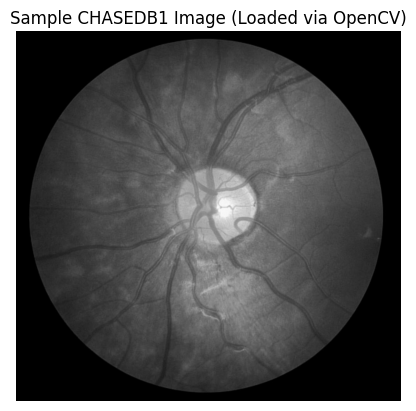

Shape: (960, 999)
Data type: uint8


In [10]:
import cv2
import matplotlib.pyplot as plt

sample_path = os.path.join(TRAIN_DATA_DIR, 'Image_01L.jpg')
sample_image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(sample_image, cmap='gray')
plt.title('Sample CHASEDB1 Image (Loaded via OpenCV)')
plt.axis('off')
plt.show()

print("Shape:", sample_image.shape)
print("Data type:", sample_image.dtype)

# Input data

In [11]:
import os

# Load file names
train_image_list = sorted(os.listdir(TRAIN_DATA_DIR))
train_segment_list = sorted(os.listdir(TRAIN_SEGMENT_DIR))

test_image_list = sorted(os.listdir(TEST_DATA_DIR))
test_segment_list = sorted(os.listdir(TEST_SEGMENT_DIR))

# Construct full paths
train_image_path_list = [os.path.join(TRAIN_DATA_DIR, x) for x in train_image_list]
train_segment_path_list = [os.path.join(TRAIN_SEGMENT_DIR, x) for x in train_segment_list]

test_image_path_list = [os.path.join(TEST_DATA_DIR, x) for x in test_image_list]
test_segment_path_list = [os.path.join(TEST_SEGMENT_DIR, x) for x in test_segment_list]

In [12]:
print(len(train_image_path_list))
print(len(train_segment_path_list))
print(len(test_image_path_list))
print(len(test_segment_path_list))

14
14
14
14


# Check data

Text(0.5, 1.0, 'Segmentation')

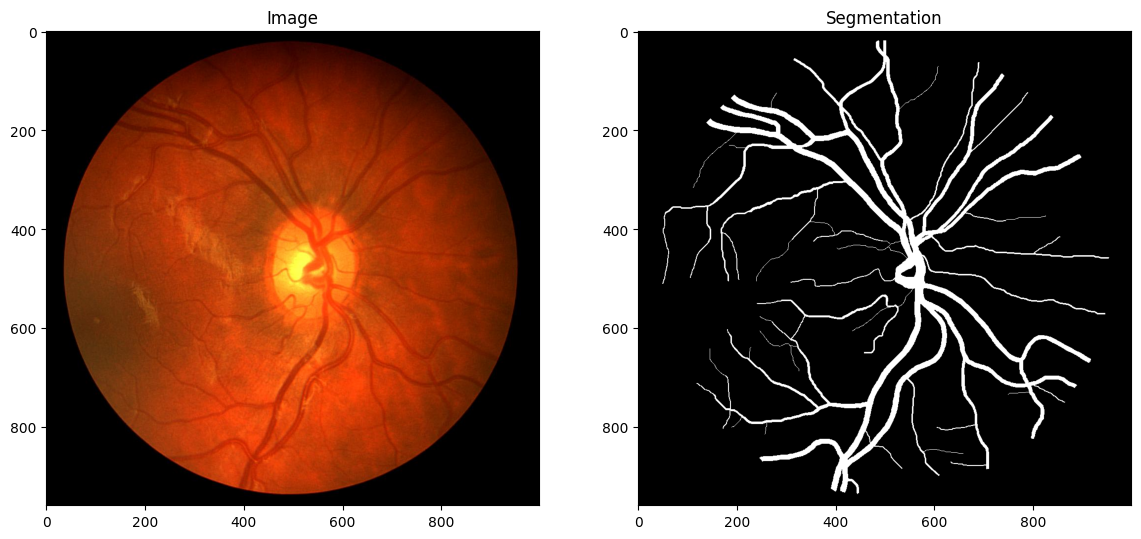

In [13]:
import matplotlib.image as mpimg
idx = 5
img = mpimg.imread(train_image_path_list[idx])
mask = mpimg.imread(train_segment_path_list[idx])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img, cmap='gray')
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='gray')
arr[1].set_title('Segmentation')

In [14]:
train_image_list_ds = tf.data.Dataset.list_files(train_image_path_list, shuffle=False)
train_mask_list_ds = tf.data.Dataset.list_files(train_segment_path_list, shuffle=False)

test_image_list_ds = tf.data.Dataset.list_files(test_image_path_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_segment_path_list, shuffle=False)

# for path in zip(train_image_list_ds.take(3), train_mask_list_ds.take(3)):
#     print(path)

In [15]:
train_image_filenames = tf.constant(train_image_path_list)
train_mask_filenames = tf.constant(train_segment_path_list)

test_image_filenames = tf.constant(test_image_path_list)
test_mask_filenames = tf.constant(test_segment_path_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_mask_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_mask_filenames))

# for image, mask in dataset.take(3):
#     print(image)
#     print(mask)
#     print()

# Preprocess data

In [16]:
!pip install tensorflow-io

In [17]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [18]:
def process_path(image_path, mask_path):
    # Load image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Load mask from 1st_manual (vessel mask)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # ensures values in [0,1]

    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (960, 960), method='nearest')
    input_mask = tf.image.resize(mask, (960, 960), method='nearest')

    return input_image, input_mask


# Apply processing and preprocessing to the training and test datasets
train_processed_image_ds = train_dataset.map(lambda x, y: preprocess(*process_path(x, y)))
test_processed_image_ds = test_dataset.map(lambda x, y: preprocess(*process_path(x, y)))


In [19]:
for image, mask in train_processed_image_ds.take(1):
    print(image.shape)
    print(image.dtype)
    print(mask.shape)
    print(mask.dtype)

(512, 512, 3)
<dtype: 'float32'>
(512, 512, 1)
<dtype: 'float32'>


# U-Net (self-implement version)

In [20]:
from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras import Input, Model
def create_U_Net(input_shape=(960,960,3)):
    inputs = Input(shape=input_shape)

    # Downward part
    x1 = Conv2D(filters= 64, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(inputs)
    x1 = Conv2D(filters= 64, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x1)

    # Downward part
    x2 = MaxPooling2D(pool_size=(2, 2), strides=2)(x1)
    x2 = Conv2D(filters= 128, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x2)
    x2 = Conv2D(filters= 128, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x2)

    # Downward part
    x3 = MaxPooling2D(pool_size=(2, 2), strides=2)(x2)
    x3 = Conv2D(filters= 256, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x3)
    x3 = Conv2D(filters= 256, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x3)

    # Downward part
    x4 = MaxPooling2D(pool_size=(2, 2), strides=2)(x3)
    x4 = Conv2D(filters= 512, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x4)
    x4 = Conv2D(filters= 512, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x4)

    # Downward part
    x5 = MaxPooling2D(pool_size=(2, 2), strides=2)(x4)
    x5 = Conv2D(filters= 1024, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x5)
    x5 = Conv2D(filters= 1024, kernel_size= (3,3), strides= 1, padding= "same" , activation="relu")(x5)

    # Upward part
    x6 = Conv2DTranspose(filters=512, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x5)
    x6 = Concatenate(axis=3)([x4, x6])
    x6 = Conv2D(filters=512, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x6)
    x6 = Conv2D(filters=512, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x6)

    # Upward part
    x7 = Conv2DTranspose(filters=256, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x6)
    x7 = Concatenate(axis=3)([x3, x7])
    x7 = Conv2D(filters=256, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x7)
    x7 = Conv2D(filters=256, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x7)

    # Upward part
    x8 = Conv2DTranspose(filters=128, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x7)
    x8 = Concatenate(axis=3)([x2, x8])
    x8 = Conv2D(filters=128, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x8)
    x8 = Conv2D(filters=128, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x8)

    # Upward part
    x9 = Conv2DTranspose(filters=64, kernel_size = (3,3), strides=(2,2), padding="same", activation="relu")(x8)
    x9 = Concatenate(axis=3)([x1, x9])
    x9 = Conv2D(filters=64, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x9)
    x9 = Conv2D(filters=64, kernel_size = (3,3), strides=1, padding="same", activation="relu")(x9)

    # Classification
    outputs = Conv2D(filters=1, kernel_size = (1,1), activation='sigmoid')(x9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

my_unet = create_U_Net()
my_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  4,719,104 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_7[0][0], 

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#import tensorflow as tf
#tf.keras.utils.plot_model(
#    my_unet,
#    to_file="model.png",
#    show_shapes=True,
#    show_dtype=False,
#    show_layer_names=True,
#    rankdir="TB",
#    expand_nested=True,
#    dpi=96
#)

# U-net method 1

In [22]:
# def double_conv_block(x, n_filters):
#     # Conv2D then ReLU activation
#     x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#     # Conv2D then ReLU activation
#     x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#     return x

In [23]:
# def downsample_block(x, n_filters):
#     f = double_conv_block(x, n_filters)
#     p = layers.MaxPool2D(2)(f)
#     p = layers.Dropout(0.3)(p)
#     return f, p

In [24]:
# def upsample_block(x, conv_features, n_filters):
#     # upsample
#     x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
#     # concatenate
#     x = layers.concatenate([x, conv_features])
#     # dropout
#     x = layers.Dropout(0.3)(x)
#     # Conv2D twice with ReLU activation
#     x = double_conv_block(x, n_filters)
#     return x

In [25]:
# def build_unet_model():
#     # inputs
#     inputs = layers.Input(shape=(128,128,3))

#     # encoder: contracting path - downsample
#     # 1 - downsample
#     f1, p1 = downsample_block(inputs, 64)
#     # 2 - downsample
#     f2, p2 = downsample_block(p1, 128)
#     # 3 - downsample
#     f3, p3 = downsample_block(p2, 256)
#     # 4 - downsample
#     f4, p4 = downsample_block(p3, 512)

#     # 5 - bottleneck
#     bottleneck = double_conv_block(p4, 1024)

#     # decoder: expanding path - upsample
#     # 6 - upsample
#     u6 = upsample_block(bottleneck, f4, 512)
#     # 7 - upsample
#     u7 = upsample_block(u6, f3, 256)
#     # 8 - upsample
#     u8 = upsample_block(u7, f2, 128)
#     # 9 - upsample
#     u9 = upsample_block(u8, f1, 64)

#     # outputs
#     outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

#     # unet model with Keras Functional API
#     unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

#     return unet_model

In [26]:
# unet_model = build_unet_model()
# unet_model.summary()

In [27]:
# tf.keras.utils.plot_model(
#     unet_model,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None
# )

# U-net method 2

In [28]:
# import tensorflow as tf
# import numpy as np

# from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Conv2DTranspose
# from tensorflow.keras.layers import concatenate

In [29]:
# # UNQ_C1
# # GRADED FUNCTION: conv_block
# def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
#     """
#     Convolutional downsampling block

#     Arguments:
#         inputs -- Input tensor
#         n_filters -- Number of filters for the convolutional layers
#         dropout_prob -- Dropout probability
#         max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
#     Returns:
#         next_layer, skip_connection --  Next layer and skip connection outputs
#     """

#     ### START CODE HERE
#     conv = Conv2D(n_filters, # Number of filters
#                   3,# Kernel size
#                   activation='relu',
#                   padding='same',
#                   kernel_initializer= 'he_normal')(inputs)
#     conv = Conv2D(n_filters, # Number of filters
#                   3,# Kernel size
#                   activation='relu',
#                   padding='same',
#                   kernel_initializer= 'he_normal')(conv)
#     ### END CODE HERE

#     # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
#     if dropout_prob > 0:
#          ### START CODE HERE
#         conv = Dropout(dropout_prob)(conv)
#          ### END CODE HERE


#     # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
#     if max_pooling:
#         ### START CODE HERE
#         next_layer = MaxPooling2D(2,strides=2)(conv)
#         ### END CODE HERE

#     else:
#         next_layer = conv

#     skip_connection = conv

#     return next_layer, skip_connection

In [30]:
# # UNQ_C2
# # GRADED FUNCTION: upsampling_block
# def upsampling_block(expansive_input, contractive_input, n_filters=32):
#     """
#     Convolutional upsampling block

#     Arguments:
#         expansive_input -- Input tensor from previous layer
#         contractive_input -- Input tensor from previous skip layer
#         n_filters -- Number of filters for the convolutional layers
#     Returns:
#         conv -- Tensor output
#     """

#     ### START CODE HERE
#     up = Conv2DTranspose(
#                  n_filters,    # number of filters
#                  3,# Kernel size
#                  strides=2,
#                  padding='same')(expansive_input)

#     # Merge the previous output and the contractive_input
#     merge = concatenate([up, contractive_input], axis=3)

#     conv = Conv2D(n_filters, # Number of filters
#                   3,# Kernel size
#                   activation='relu',
#                   padding='same',
#                   kernel_initializer= 'he_normal')(merge)
#     conv = Conv2D(n_filters, # Number of filters
#                   3,# Kernel size
#                   activation='relu',
#                   padding='same',
#                   kernel_initializer= 'he_normal')(conv)
#     ### END CODE HERE

#     return conv

In [31]:
# # UNQ_C3
# # GRADED FUNCTION: unet_model
# def unet_model(input_size=(224, 224, 3), n_filters=32, n_classes=3):
#     """
#     Unet model

#     Arguments:
#         input_size -- Input shape
#         n_filters -- Number of filters for the convolutional layers
#         n_classes -- Number of output classes
#     Returns:
#         model -- tf.keras.Model
#     """
#     inputs = Input(input_size)
#     # Contracting Path (encoding)
#     # Add a conv_block with the inputs of the unet_ model and n_filters
#     ### START CODE HERE
#     cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
#     # Chain the first element of the output of each block to be the input of the next conv_block.
#     # Double the number of filters at each new step
#     cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
#     cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
#     # Include a dropout of 0.3 for this layer
#     cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
#     # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
#     cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)
#     ### END CODE HERE

#     # Expanding Path (decoding)
#     # Add the first upsampling_block.
#     # From here,at each step, use half the number of filters of the previous block
#     # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
#     ### START CODE HERE
#     ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
#     # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
#     # Note that you must use the second element of the contractive block i.e before the maxpooling layer.

#     ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
#     ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
#     ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)
#     ### END CODE HERE

#     conv9 = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(ublock9)

#     # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
#     ### START CODE HERE
#     conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
#     ### END CODE HERE

#     model = tf.keras.Model(inputs=inputs, outputs=conv10)

#     return model

In [32]:
# img_height = 224
# img_width = 224
# num_channels = 3

# unet = unet_model(input_size=(img_height, img_width, num_channels),n_filters=32,  n_classes=1)

In [33]:
# tf.keras.utils.plot_model(
#     unet,
#     to_file="model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96
# )

In [34]:
# unet.summary()

# Loss function

In [35]:
import tensorflow.keras.backend as K
#Keras
def dice_loss(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets) #tf.keras.layers.Flatten()

    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

In [36]:
#Keras
def dice_score(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs) #tf.keras.layers.Flatten()
    targets = K.flatten(targets)

    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return dice

In [37]:
# #Keras
# def DiceBCELoss(targets, inputs, smooth=1e-6):

#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)

#     BCE =  binary_crossentropy(targets, inputs)
#     intersection = K.sum(K.dot(targets, inputs))
#     dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
#     Dice_BCE = BCE + dice_loss

#     return Dice_BCE

In [38]:
# #Keras
# def IoULoss(targets, inputs, smooth=1e-6):

#     #flatten label and prediction tensors
#     inputs = K.flatten(inputs)
#     targets = K.flatten(targets)

#     intersection = K.sum(K.dot(targets, inputs))
#     total = K.sum(targets) + K.sum(inputs)
#     union = total - intersection

#     IoU = (intersection + smooth) / (union + smooth)
#     return 1 - IoU

In [39]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook#Dice-Loss
# https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html

In [40]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + 1e-6) / (K.sum(y_truef) + K.sum(y_predf) + 1e-6))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# def iou(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     sum_ = K.sum(y_true + y_pred)
#     jac = (intersection + 100) / (sum_ - intersection + 100)
#     return jac

# Dataset Handling

In [41]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(512, 512, 1)


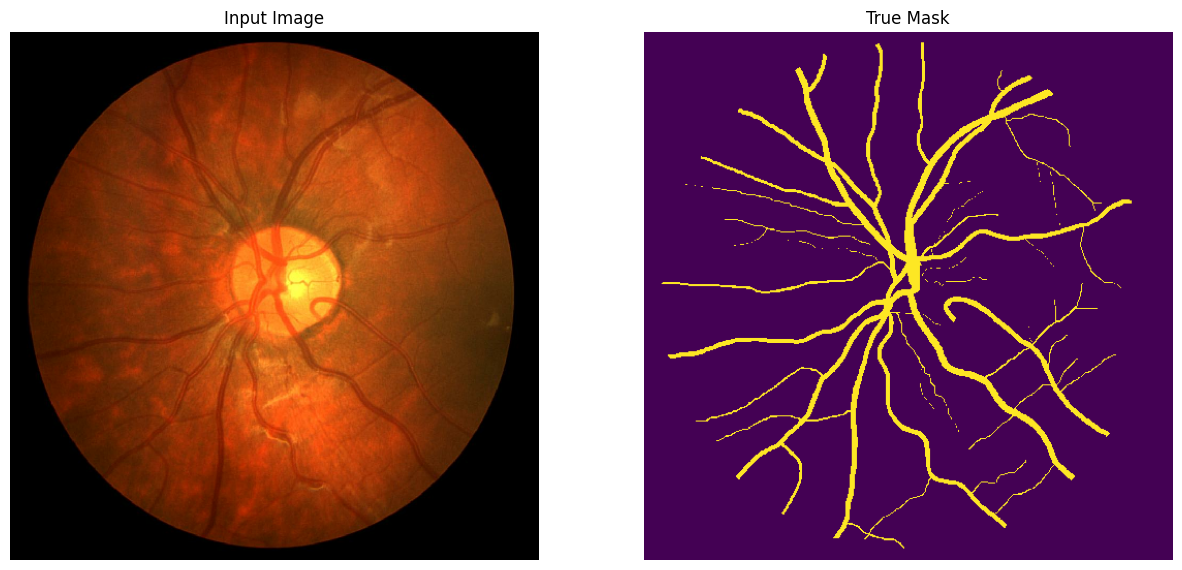

In [42]:
for image, mask in train_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(512, 512, 1)


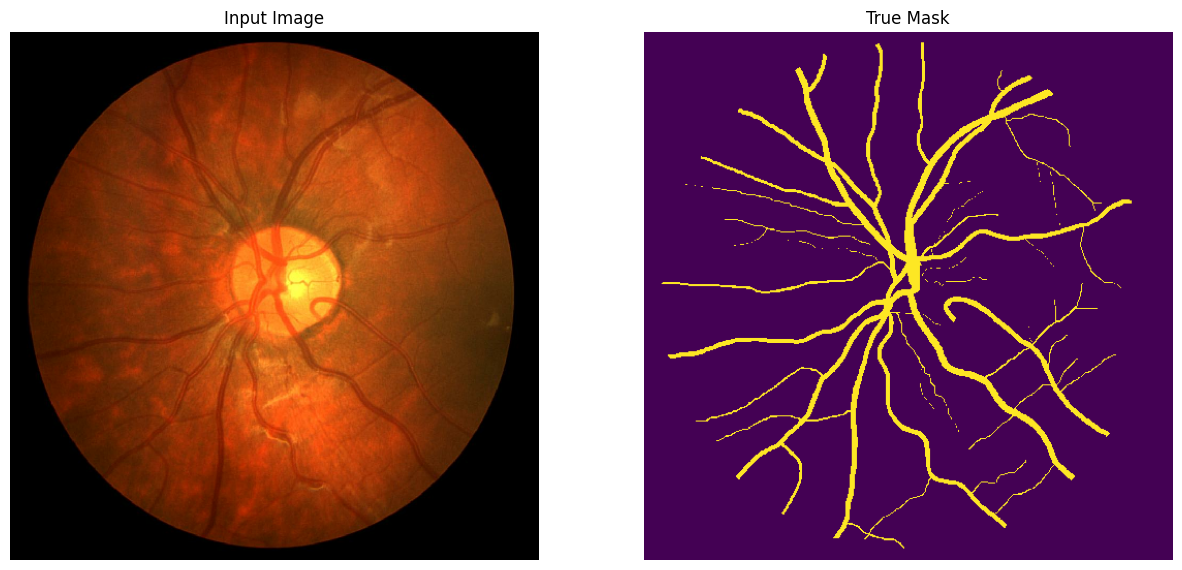

In [43]:
for image, mask in train_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(512, 512, 1)


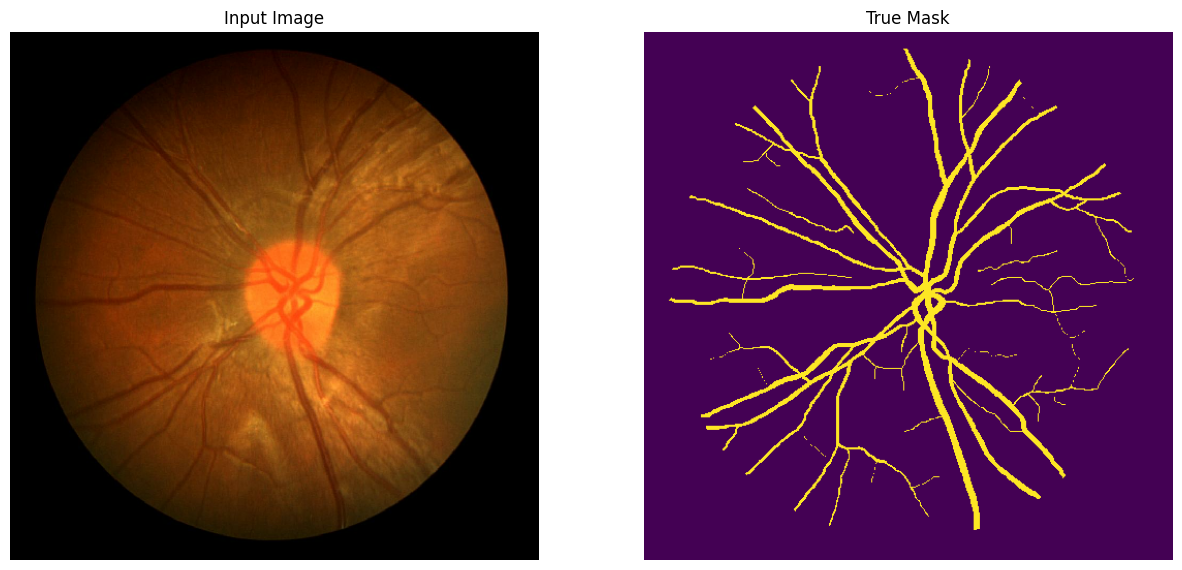

In [44]:
for image, mask in test_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

# Train the Model

In [45]:
# unet.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #dice_coef_loss
#               metrics="accuracy") #dice_coef

my_unet.compile(
    optimizer='adam',
    loss=dice_coef_loss,
    metrics=[dice_coef]  # Use this instead of "accuracy"
)

In [ ]:
EPOCHS = 30
BUFFER_SIZE = 32
BATCH_SIZE = 32

# train_processed_image_ds.batch(BATCH_SIZE)
# test_processed_image_ds.batch(BATCH_SIZE)

train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(train_processed_image_ds.element_spec)
print(test_processed_image_ds.element_spec)
# model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)
model_history = my_unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, verbose=1)

(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))
Epoch 1/30


# Plot Model Accuracy

In [ ]:
import matplotlib.pyplot as plt

# Plot Dice Coefficient
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(model_history.history['val_dice_coef'], label='Val Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
final_train_dice = model_history.history['dice_coef'][-1]
final_val_dice = model_history.history['val_dice_coef'][-1]
final_train_loss = model_history.history['loss'][-1]
final_val_loss = model_history.history['val_loss'][-1]

print("Final Train Dice Coefficient:", round(final_train_dice, 4))
print("Final Val Dice Coefficient:", round(final_val_dice, 4))
print("Final Train Loss:", round(final_train_loss, 4))
print("Final Val Loss:", round(final_val_loss, 4))


# Model evaluation

In [ ]:
evaluation_results = my_unet.evaluate(test_dataset)
print("test loss, test acc:", evaluation_results)

# Show Predictions

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.round(pred_mask)
#     pred_mask = tf.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = my_unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(my_unet.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
# for image, mask in train_dataset.take(1):
# #     plt.imshow(image[0]*255.0)
#     pred_mask = unet.predict(image)
# #     print(pred_mask[0].shape)
# #     print(pred_mask[0].dtype)
#     plt.imshow(pred_mask[0])
# #     plt.imshow(pred_mask*255.0)

In [ ]:
show_predictions(train_dataset, 10)

In [ ]:
# Get a sample image and its true mask
for image, mask in test_processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    break

# Predict vessel segmentation
# Add batch dimension before prediction
prediction = my_unet(tf.expand_dims(sample_image, axis=0), training=False)
pred_mask = tf.squeeze(prediction, axis=0)  # Remove batch dimension

# Binarize prediction (vessel vs background)
pred_mask_bin = tf.where(pred_mask > 0.5, 1.0, 0.0)

# Display input image, ground truth mask, and predicted vessel mask
def display(display_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Vessel Mask (Ground Truth)', 'Predicted Vessel Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

display([sample_image, sample_mask, pred_mask_bin])


# Segmentation Models

In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

In [ ]:
from segmentation_models import Unet

seg_model = Unet('resnet34')

In [ ]:
seg_model.summary()

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    seg_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)